# Task 3: Simulation of a GBS experiment

A template code for calculating a vibronic spectrum of $V_3$ using a sampling method, simulating a Gaussian Boson Sampling experiment.

Input Parameters.

Note: "Strawberry Fields" is a code created by Xanadu and is the driver behind GBS. This can be installed using **pip**, but see install instructions in the <a href="https://github.com/CDL-Quantum/CohortProject_2020/blob/master/Project_3_Franck_Condon_Factors/Project3_LandingPage.pdf"> Project 3 Landing Page</a>. Plotly is a nice plotting code, but is not necessary if you wish to use one of your choice.

In [1]:
from sys import argv
from strawberryfields.apps import vibronic, data, sample, plot
import numpy as np
from utils import get_state, plot_spectrum, plot_spectrum_from_samples
from plotly import offline
offline.init_notebook_mode(connected = True)

Variables.

Note: The **inputfile** for $V_3$ is what you will have to create to run this script.

In [2]:
# inputfile = open(argv[1], "r")
inputfile = open("Task2Code/output/V3.duschinsky.out", "r")

N=int(inputfile.readline())     #Number of Atoms
nmodes=3*N-6                    #Number of Modes

w=np.zeros(nmodes,float)        #vib. frequencies of ground electronic state
wp=np.zeros(nmodes,float)       #vib. frequencies of excited electronic state
Ud=np.zeros((nmodes,nmodes),float)   #Duschinsky Matrix
delta=np.zeros(nmodes,float)    #Displacement Vector

T = 500  # temperature

Read in Parameters.

The code below assumes, that the input file has the following structure
```
1 line: number of atoms
1 line: space-separated list of normal frequencies of the ground state
1 line: space-separated list of normal frequencies of the excited state
nmodes lines: each line space-separated numbers representing a row in Duschinsky matrix
1 line: space-separated list of displacements
```

In [3]:
w = np.array([float(x) for x in inputfile.readline().split()])
wp = np.array([float(x) for x in inputfile.readline().split()])
for i in range(nmodes):
    Ud[i, :] = np.array([float(x) for x in inputfile.readline().split()])
delta = np.array([float(x) for x in inputfile.readline().split()])

Use "Strawberry Fields" to calculate GBS Parameters based on the frequencies, Duschinsky matrix, and temperature that was provided as input.

In [4]:
t, U1, r, U2, alpha = vibronic.gbs_params(w, wp, Ud, delta, T)

Generate Samples and Calculate Energies of Samples.

Note: The number of samples may be changed if the spectrum is not converged.

In [5]:
nr_samples = 50
s = sample.vibronic(t, U1, r, U2, alpha, nr_samples)
e = vibronic.energies(s, w, wp)

To plot the spectrum we use the function `plot_spectrum_from_samples` we have implemented in `utils.py`, which is using matplotlib to do the plotting.

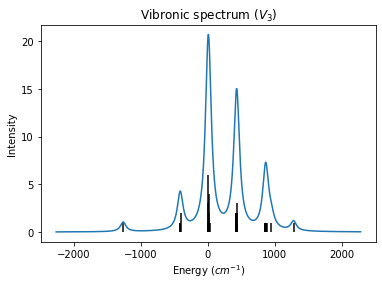

In [6]:
plot_spectrum_from_samples(e, "Vibronic spectrum ($V_3$)")

For now I am leaving the original plotting from strawberryfields here, just to compare our plot with this one. In the final version this will be removed.

In [7]:
spectrum = plot.spectrum(e, xmin=-600, xmax=2000)
offline.iplot(spectrum)

### Challenge 1

Instead of sampling a photonic devie and approximating the probabilities of output energies based on the sampling results, we can compute the exact probabilities of the outputs using loop hafnians. Let us calculate the exact probabilities of the samples we got above.

TODO: add more explanations

In [8]:
s_unique = list(set([tuple(item) for item in s]))
s_unique = [list(x) for x in s_unique]

e_unique = vibronic.energies(s_unique, w, wp)

state = get_state(t, U1, r, U2, alpha)
probs = [state.fock_prob(pattern, cutoff=20) for pattern in s_unique]

And we plot the result

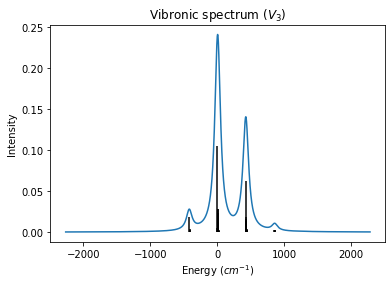

In [9]:
plot_spectrum(np.vstack([e_unique, probs]), "Vibronic spectrum ($V_3$)")